# Density of States Analysis Example

This example demonatrates a routine procedure of calculating phonon density of states
from an experimental NeXus data file for a powder vanadium sample measured at ARCS,
a direct-geometry neutron chopper spectrometer at the Spallation Neutron Source (SNS),
Oak Ridge National Lab.


## Summary of processing steps

* Gather experimental information and experimental raw data
* Reduce raw data to S(Q,E), the experimental dynamical structure factor, and inspect
* Convert S(Q,E) to phonon DOS

## Preparation

Get python tools ready

In [1]:
import os, numpy as np
import histogram.hdf as hh, histogram as H
from matplotlib import pyplot as plt
%matplotlib notebook
# %matplotlib inline

from multiphonon import getdos
from multiphonon.sqe import plot as plot_sqe

Create a new working directory and change into it. All inputs, intermediate results and final outputs will be in this new directory.

In [2]:
projectdir = os.path.abspath('./V_Ei120meV-noUI')
!mkdir -p {projectdir}
%cd {projectdir}

/SNS/users/lj7/dv/sns-chops/multiphonon/examples/V_Ei120meV-noUI


## Get experimental data

For SNS users, experimental data are available in /SNS/"instrument_name"/IPTS-#### folders at the SNS analysis cluster.
Here we will download the required data file from web.

Build download command

In [3]:
dest = 'ARCS_V_annulus.nxs'
url = "https://www.dropbox.com/s/tbh4jcwiags410d/ARCS_V_annulus.nxs?dl=1"
cmd = 'wget %r -O %r' % (url, dest)
print cmd

wget 'https://www.dropbox.com/s/tbh4jcwiags410d/ARCS_V_annulus.nxs?dl=1' -O 'ARCS_V_annulus.nxs'


Download: this will take a while (can be a few minutes to an hour, depending on internet speed)

In [4]:
%%time
!{cmd} >log.download 2>err.download

CPU times: user 172 ms, sys: 24 ms, total: 196 ms
Wall time: 9.96 s


The following command should show the downloaded file "ARCS_V_annulus.nxs"

In [5]:
ls

ARCS_V_annulus.nxs  err.download  log.download


## Experimental data and condition

To start, we need to set the locations of the data files measured for the sample and empty can (for background correction), as well as the experimental conditions such as incident neutron energy (Ei, in meV) and sample temperature (T, in Kelvin).

The example inputs explained:

* samplenxs: ARCS_V_annulus.nxs we just downloaded
* mtnxs: None. This means we will skip the empty can background correction for this example.
* Ei: 120. This is set by Fermi chopper settings during the experiment. An approximate number is fine. The actual Ei will be caculated from the experimental NeXus file.
* T: 300. This is set by sample environment. For room temperature measurement, use 300 (K).

In [6]:
samplenxs = './ARCS_V_annulus.nxs'
mtnxs = None
Ei = 120
T = 300

## Obtain S(Q,E)

Now we are ready to reduce the experimental data to obtain the dynamical structure factor, S(Q,E). 

S(Q,E) spectra for both the sample and the empty can is the starting point for getdos processing. 

The Q and E axes need to be define:

* E axis
  - Emin: -115. Usually -Ei
  - Emax: 115. Usually slightly smaller than Ei
  - dE: 1. Usually Ei/100
* Q axis
  - Qmin: 0. Usually 0
  - Qmax: 17. Usually 2 X E2Q(Ei)
  - dQ: 0.1.  Usually Emax/100

In [7]:
Qaxis = Qmin, Qmax, dQ = 0, 17, 0.1
Eaxis = Emin, Emax, dE = -115., 115., 1.
iqe_h5_path = 'iqe.h5'

In [8]:
from multiphonon import getdos

In [9]:
%%time
for m in getdos.reduce2iqe(samplenxs, 
                           Emin=Emin, Emax=Emax, dE=dE, Qmin=Qmin, Qmax=Qmax, dQ=dQ, 
                           iqe_h5=iqe_h5_path, workdir='work'):
    print m

Converting sample data to powder I(Q,E)...
* Checking Mantid ...
  - Done.
Results: sample IQE, MT IQE, Qaxis, Eaxis
('/SNS/users/lj7/dv/sns-chops/multiphonon/examples/V_Ei120meV-noUI/work/iqe.h5', None, (0, 17.05, 0.1), (-115.0, 115.5, 1.0))
CPU times: user 50min 26s, sys: 13.6 s, total: 50min 40s
Wall time: 4min 2s


/home/lj7/miniconda2/envs/dev-mph/lib/python2.7/site-packages/histogram/hdf/Loader.py:129: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'storage' in list(dataGroup): # this uses the 'storage' convention


In [10]:
ls -tl work/iqe.h5

-rw-r--r-- 1 lj7 users 440568 Jan  4 16:58 work/iqe.h5


Plot sample IQE

<IPython.core.display.Javascript object>


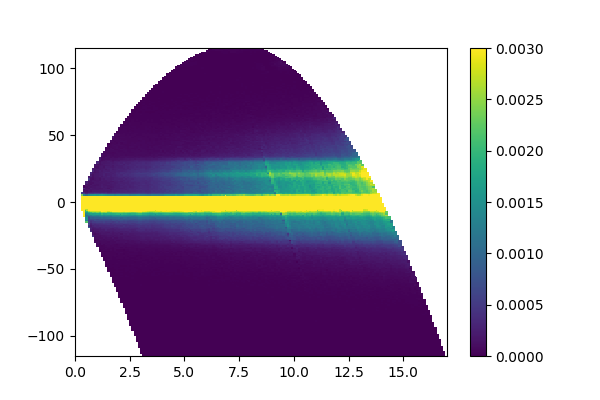

In [11]:
iqe = hh.load('work/iqe.h5')

plt.figure(figsize=(6,4))
plot_sqe(iqe)
# plt.xlim(0, 11)
plt.clim(0, 3e-3)

This is a plot of vanadium S(Q, E) histogram.
* The colored region is within the dynamical range of the measurement
* Vanadium is incoherent, therefore the intensity is mostly momentum-independent
* Make sure the energy and momentum transfer axes are reasonable so that the S(Q,E) spectrum looks reasonable
* You can improve the Q,E axis parameters if you like, by re-executing the relevant cells above

Now integreate over the Q (momentum transfer) axis to obtain energy spectrum I(E)

<IPython.core.display.Javascript object>


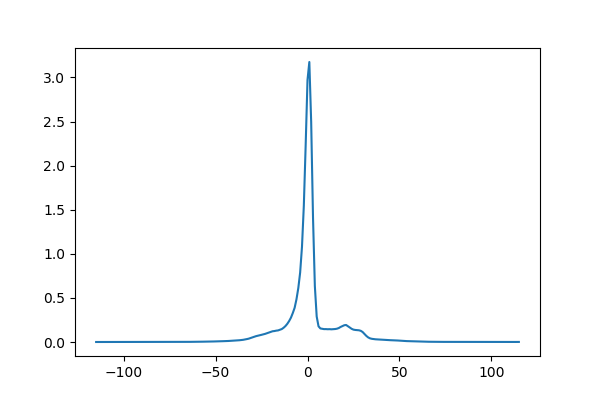

In [12]:
iqe2 = iqe.copy()
I = iqe2.I; I[I!=I] = 0     # remove NaNs
IE = iqe2.sum('Q')          # sum over Q
plt.figure(figsize=(6,4))
plt.plot(IE.energy, IE.I)

* At the center of this plot there is an enormous peak that is due to elastic scattering, which should be excluded from the phonon DOS calculation
* Zoom in to see the rough range of the elastic peak and take notes. We need them in the analysis below.

## Run GetDOS

Phonon DOS will be obtained from SQE histogram by an iterative procedure where multiphonon and multiple scattering corrections are applied to the measured SQE spectrum, assuming
incoherent approximation, and the corrected spectrum
is then converted to DOS.

Input parameters
  - Emin, Emax of elastic peak: -15, 7. Make an estimate from the I(E) spectrum
  - Average atomic mass: 50.94. Atomic mass of vanadium
  - mt_faction: 0.9. Depends on the geometrical property of the sample and the empty can. Usually between 0.9 and 1.
  - Max phonon energy: 40.
  - C_ms: 0.26: Ratio of multiple scattering to multiphon scattering. Depends on sample shape.
  - const_bg_fraction: 0.004: Background noise level.
  

In [13]:
for msg in getdos.getDOS(
    samplenxs, mt_fraction=0.9, const_bg_fraction=0.004,
    Emin=Emin, Emax=Emax, dE=dE, Qmin=Qmin, Qmax=Qmax, dQ=dQ,
    T=300., Ecutoff=40.,
    elastic_E_cutoff=(-15, 7.),
    M=50.94,
    C_ms = 0.26,
    Ei = 120,
    initdos=None, 
    workdir = 'work'
    ):
    print msg

Converting sample data to powder I(Q,E)...
Results: sample IQE, MT IQE, Qaxis, Eaxis
('/SNS/users/lj7/dv/sns-chops/multiphonon/examples/V_Ei120meV-noUI/work/iqe.h5', None, (0, 17.05, 0.1), (-115.0, 115.5, 1.0))


/home/lj7/dv/sns-chops/multiphonon/multiphonon/getdos.py:236: UserWarning: Reusing old reduction result from /SNS/users/lj7/dv/sns-chops/multiphonon/examples/V_Ei120meV-noUI/work/iqe.nxs
  warnings.warn(msg)


Iterative computation of DOS...
Finished round #1
Finished round #2
Finished round #3
Finished round #4
Finished round #5
Done


## Check output

Results are saved in "work" directory

In [14]:
ls work/

dirdydos/        iqe.nxs                 residual_E-posE.h5  round-3/
final-dos.h5     plot_dos_iteration.py*  round-0/            round-4/
I_E-exp-posE.h5  plot_residual.py*       round-1/
iqe.h5           raw2iqe-sample.params   round-2/


Plot the final result for DOS

<IPython.core.display.Javascript object>


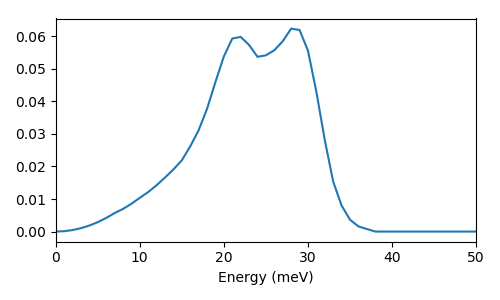

In [15]:
dos = hh.load('work/final-dos.h5')
plt.figure(figsize=(5,3))
plt.plot(dos.E, dos.I)
plt.xlabel('Energy (meV)')
plt.xlim(0, 50)
plt.tight_layout()

More plotting utils are available

In [16]:
from multiphonon.backward import plotutils as pu

<IPython.core.display.Javascript object>


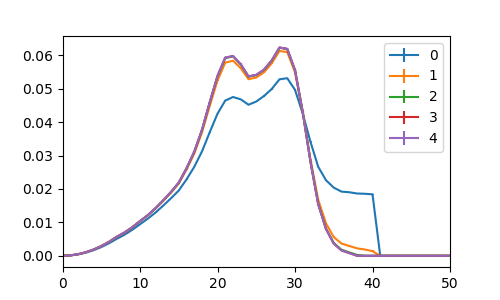

(0, 50)

In [17]:
plt.figure(figsize=(5,3))
pu.plot_dos_iteration('work/')
plt.xlim(0, 50)

<IPython.core.display.Javascript object>


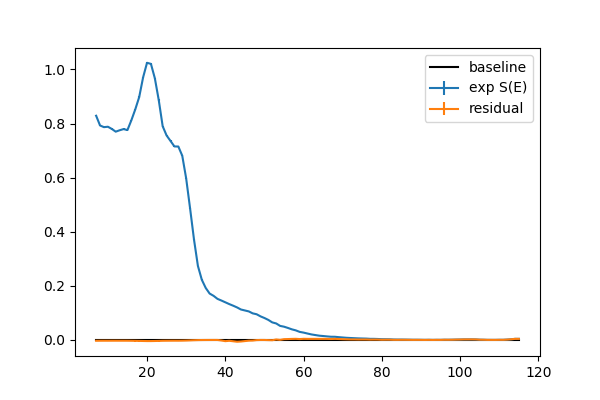

In [18]:
plt.figure(figsize=(6,4))
pu.plot_residual('work/')

<IPython.core.display.Javascript object>


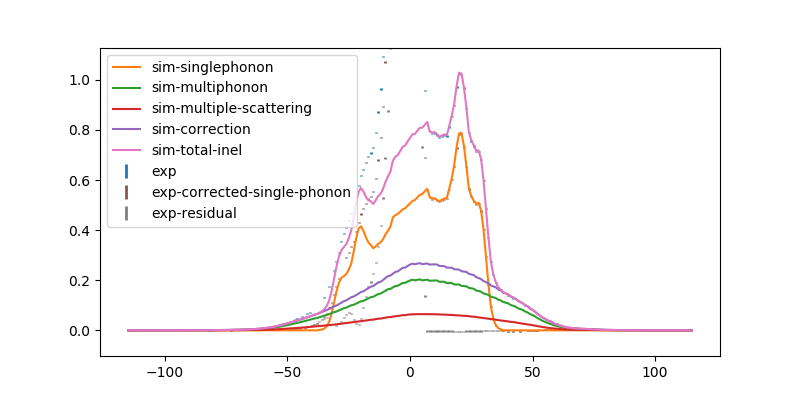

In [19]:
plt.figure(figsize=(8, 4))
pu.plot_intermediate_result_se('work/round-4')